In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')

# Upload Scores to DWH

In [2]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019_cl.pkl")

In [3]:
df= df[["SKP_CREDIT_CASE","PRED_INCOME"]]

In [4]:
df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_upload_dwh.csv", index = False)

In [5]:
#upload to TBD_INCOME_PRED

# Read Data File

In [8]:
df= pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019_cl.pkl")


In [9]:
df1 = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\combined_income_pred.pkl")

In [10]:
df1= df1[['SKP_CREDIT_CASE','CLIENT_DEBT', 'CLIENT_EMI','NTC_FLAG']]

In [11]:
df = df.merge(df1, on= 'SKP_CREDIT_CASE', how = 'inner')

In [12]:
df.shape

(457172, 12)

# Create features for Analysis 

In [14]:
df.columns= ['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FSTQPD30',  'GRID_ID', 'REPORTED_INCOME',
       'MONTH_STR', 'PRED_INCOME', 'CLIENT_DEBT', 'CLIENT_EMI', 'NTC_FLAG']

In [15]:
features_list = ["REPORTED_INCOME","PRED_INCOME","MIN_INCOME","RATIO_PRED_REPORTED_INCOME","DTI_PRED_INCOME","DTI_REPORTED_INCOME","DTI_MIN_INCOME"]

In [16]:
df["MIN_INCOME"] = df[['REPORTED_INCOME','PRED_INCOME']].min(axis=1)

In [17]:
df["RATIO_PRED_REPORTED_INCOME"] = df['PRED_INCOME']/df['REPORTED_INCOME']

In [18]:
df["DTI_PRED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["PRED_INCOME"][x] for x in df.index]
df["DTI_REPORTED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["REPORTED_INCOME"][x] for x in df.index]
df["DTI_MIN_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["MIN_INCOME"][x] for x in df.index]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df.shape

(457172, 17)

In [20]:
df = df[~df["MIN_INCOME"].isin([0,np.inf,np.nan])]

In [21]:
df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_v1_cl.pkl")

# MOM R Square

In [22]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

In [23]:
dic= {"MONTH_STR":[],"RMSE":[],"R_SQUARED":[]}
for x in df.MONTH_STR.unique():
    dic["MONTH_STR"].append(x)
    dic["RMSE"].append(round(np.sqrt(mse(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))))
    dic["R_SQUARED"].append(r2_score(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))
    
r_sq_df = pd.DataFrame(dic)

r_sq_df

,MONTH_STR,RMSE,R_SQUARED
0,2019-01,11550.0,0.029022
1,2019-02,11725.0,0.032356
2,2019-03,11849.0,0.032719
3,2019-04,11809.0,0.031765
4,2019-05,11906.0,0.028277
5,2019-06,12142.0,0.025552
6,2019-07,12082.0,0.028702
7,2019-08,11856.0,0.029472


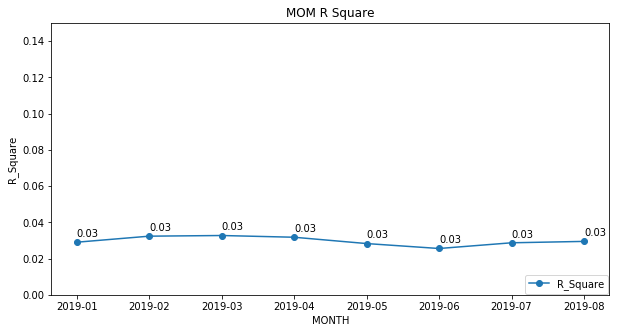

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(r_sq_df["MONTH_STR"],r_sq_df["R_SQUARED"], marker = 'o', label = 'R_Square')

for i, txt in enumerate(r_sq_df["R_SQUARED"]):
    plt.annotate("{:.2f}".format(txt), (r_sq_df["MONTH_STR"][i], r_sq_df["R_SQUARED"][i]+0.003))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,0.15)
plt.ylabel("R_Square")
plt.xlabel("MONTH")
ax1.set_title("MOM R Square")
plt.show()

# Gini and IV of Features for Comparison

In [25]:
df1=df

### Reduce sample size to reduce computation in calculations for IV, Gini

In [44]:
df = df1.sample(n=300000,random_state=2)

In [45]:
for x in features_list:
    df[x+"_BINS"] = pd.qcut(df[x],10,duplicates = 'drop')

In [46]:
from scoring.metrics import iv,gini
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
        power_tab["VARIABLE_NAME"].append(cols_list[j])
        power_tab["IV"].append("{:.2%}".format(iv(df[col_target],df[cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.2%}".format((2*metrics.roc_auc_score(df[col_target],df[cols_list[j]])-1)))
        print(cols_list[j])

REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME


In [48]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)
power_out["GINI"] = (power_out["GINI"])

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\gini_iv.csv")

,IV,GINI
VARIABLE_NAME,,
REPORTED_INCOME,2.88%,9.77%
MIN_INCOME,2.73%,9.45%
DTI_REPORTED_INCOME,2.06%,7.66%
PRED_INCOME,0.97%,4.80%
DTI_PRED_INCOME,13.21%,19.91%
DTI_MIN_INCOME,7.65%,13.52%
RATIO_PRED_REPORTED_INCOME,2.55%,-9.06%


### To make MOM calculations of IV, GINI

In [ ]:
from scoring.metrics import iv,gini,lift
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'MONTH':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
    for k in df.MONTH_STR.unique():
        power_tab["VARIABLE_NAME"].append(j)
        power_tab["MONTH"].append(k)
        power_tab["IV"].append("{:.1%}".format(iv(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.1%}".format((2*metrics.roc_auc_score(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]])-1)))

In [ ]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('Gini',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_gini_iv.csv")

# WOE Analysis

In [32]:
df=df1
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 4, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [33]:
cols_pred_num=features_list
cols_pred_cat = []

In [36]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=4, 
                    min_samples=10000)

grouping.fit(df_train[cols_pred_num],
             df_train["RISK_FSTQPD30"],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

grouping.save(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\my_grouping")

data_woe = grouping.transform(df, transform_to='woe', progress_bar=True)

'Grouping saved on 2020-04-08 18:11:09 to file C:\\Users\\aman.khatri91425\\Desktop\\HomeCredit\\Bigdata\\Common Maps KNN\\my_grouping'

### Plot Bins

***

### DTI_MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_MIN_INCOME,,,,,,,,
"[-inf, 0.2347)",37371.0,552.0,0.0148,0.1362,0.2388,0.5346,0.5618,0.2362
"[0.2347, 0.3032)",25989.0,566.0,0.0218,0.1396,0.1649,0.1598,0.1664,0.1642
"[0.3032, 0.4033)",37948.0,1071.0,0.0282,0.2642,0.2392,-0.0959,-0.0994,0.2398
"[0.4033, inf)",56924.0,1865.0,0.0328,0.4600,0.3571,-0.2450,-0.2533,0.3598
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.0904
Gini: 15.45


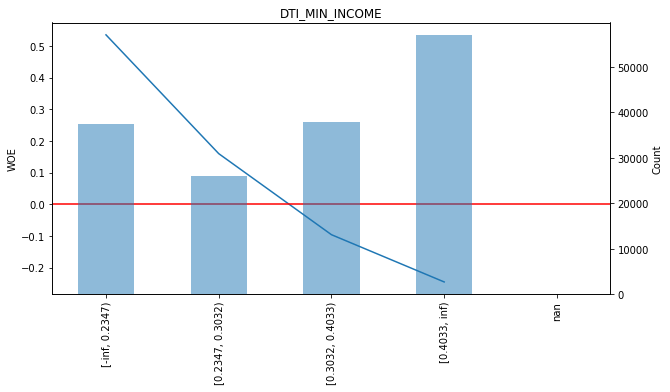

***

### DTI_PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_PRED_INCOME,,,,,,,,
"[-inf, 0.2023)",46375.0,632.0,0.0136,0.1559,0.2967,0.6110,0.6435,0.2931
"[0.2023, 0.3032)",47060.0,1075.0,0.0228,0.2652,0.2983,0.1130,0.1176,0.2974
"[0.3032, 0.3698)",28847.0,920.0,0.0319,0.2269,0.1811,-0.2180,-0.2254,0.1823
"[0.3698, inf)",35950.0,1427.0,0.0397,0.3520,0.2239,-0.4389,-0.4524,0.2272
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.1628
Gini: 21.90


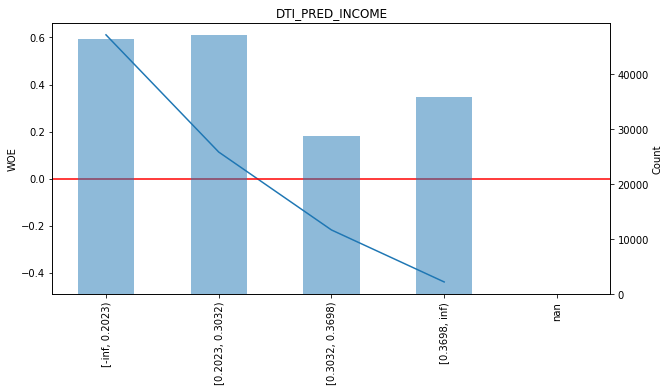

***

### DTI_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_REPORTED_INCOME,,,,,,,,
"[-inf, 0.1744)",29563.0,540.0,0.0183,0.1332,0.1882,0.3309,0.3459,0.1868
"[0.1744, 0.2347)",24906.0,564.0,0.0226,0.1391,0.1579,0.1216,0.1265,0.1574
"[0.2347, 0.4346)",65140.0,1763.0,0.0271,0.4349,0.4111,-0.0543,-0.0563,0.4117
"[0.4346, inf)",38623.0,1187.0,0.0307,0.2928,0.2428,-0.1809,-0.1872,0.2441
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.0321
Gini: 9.37


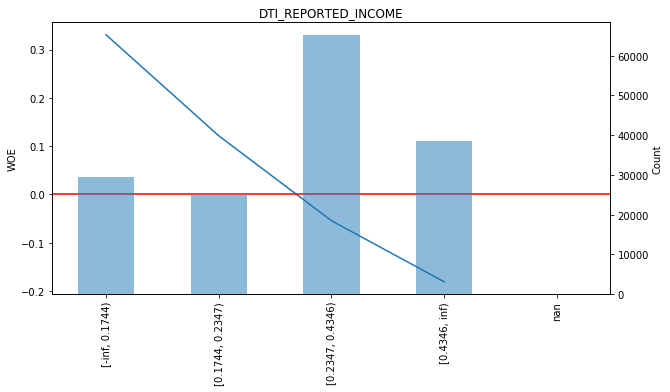

***

### MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_MIN_INCOME,,,,,,,,
"[-inf, 14199.7002)",35058.0,711.0,0.0203,0.1754,0.2228,0.2293,0.2392,0.2216
"[14199.7002, 19874.9141)",55619.0,1333.0,0.0240,0.3288,0.3521,0.0658,0.0684,0.3515
"[19874.9141, 22038.0381)",35490.0,988.0,0.0278,0.2437,0.2238,-0.0823,-0.0853,0.2243
"[22038.0381, inf)",32065.0,1022.0,0.0319,0.2521,0.2013,-0.2174,-0.2248,0.2026
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.0260
Gini: 8.95


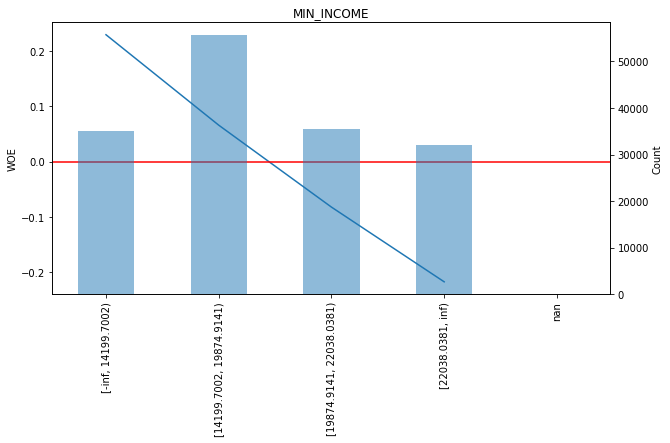

***

### PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PRED_INCOME,,,,,,,,
"[-inf, 18856.8916)",16492.0,408.0,0.0247,0.1006,0.1043,0.0346,0.0359,0.1042
"[18856.8916, 20920.501)",35718.0,780.0,0.0218,0.1924,0.2266,0.1571,0.1636,0.2257
"[20920.501, 25076.6963)",95403.0,2530.0,0.0265,0.6241,0.6024,-0.0341,-0.0354,0.6029
"[25076.6963, inf)",10619.0,336.0,0.0316,0.0829,0.0667,-0.2101,-0.2173,0.0671
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.0100
Gini: 4.89


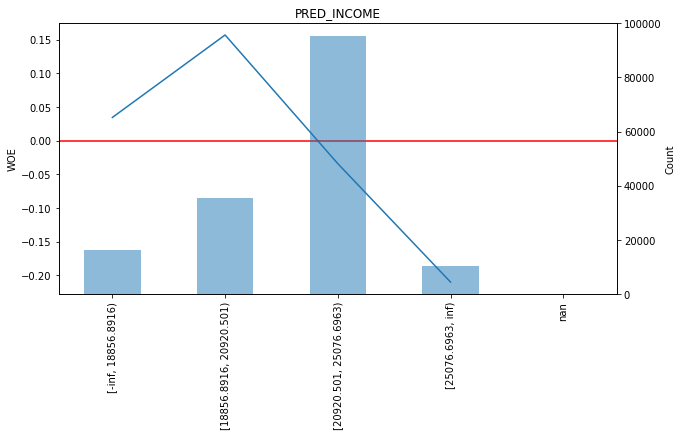

***

### RATIO_PRED_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_RATIO_PRED_REPORTED_INCOME,,,,,,,,
"[-inf, 0.65)",21361.0,697.0,0.0326,0.1719,0.1340,-0.2409,-0.2490,0.1350
"[0.65, 0.9271)",30122.0,886.0,0.0294,0.2185,0.1896,-0.1371,-0.1420,0.1904
"[0.9271, 1.4071)",56015.0,1397.0,0.0249,0.3446,0.3543,0.0266,0.0276,0.3540
"[1.4071, inf)",50734.0,1074.0,0.0212,0.2649,0.3221,0.1875,0.1954,0.3206
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.0250
Gini: 8.73


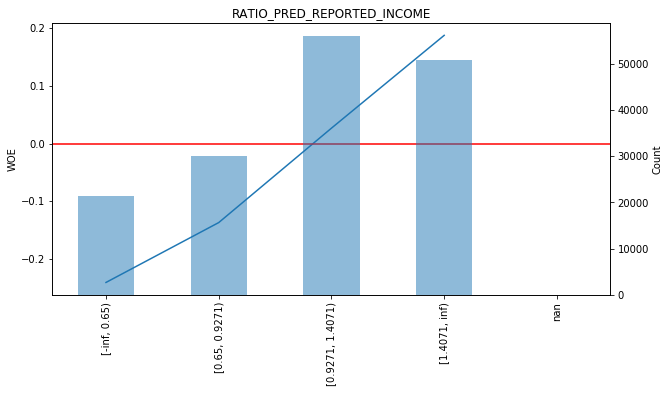

***

### REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_REPORTED_INCOME,,,,,,,,
"[-inf, 17999.9004)",67598.0,1451.0,0.0215,0.3579,0.4290,0.1740,0.1812,0.4272
"[17999.9004, 28599.7002)",54869.0,1436.0,0.0262,0.3542,0.3466,-0.0210,-0.0218,0.3468
"[28599.7002, 41450.0)",25296.0,860.0,0.0340,0.2121,0.1585,-0.2822,-0.2915,0.1599
"[41450.0, inf)",10469.0,307.0,0.0293,0.0757,0.0659,-0.1341,-0.1388,0.0662
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6384,0.0000


IV: 0.0301
Gini: 9.34


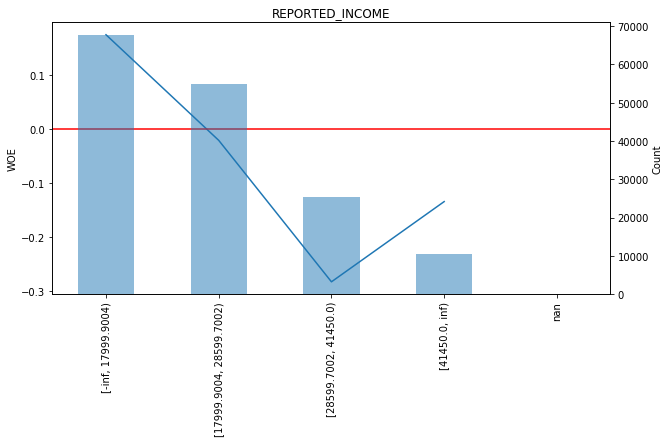

In [37]:
grouping.plot_bins(data=df_train, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask = pd.Series(df_train["REPORTED_INCOME"]>=0),col_target="RISK_FSTQPD30", 
                   output_folder=r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN", col_weight=None)

In [152]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in df:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
df = df.drop(woe_columns_to_replace, axis='columns')
df = df.join(-data_woe)

print('Added WOE variables. Number of columns:',df.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred_num]

Added WOE variables. Number of columns: 25
